In [71]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
from typing import Callable, Tuple
# 下面的数组均使用numpy的多维数组

# 神经元

神经元是神经网络中的基础单元，它包含输入，权重，偏置，输出，激活函数等概念；一个神经元有多个**输入**，每个输入端均有自己的**权重**，将神经元的每一个输入都和自己的权重相乘，将结果相加，最后再和**偏置**相加，将结果传递给**激活函数**，得到的便是神经元的输出；神经元可以有多个输出，它们的值相同。使用代码表达的话，神经元的输出为：

In [72]:
def output(xs, ws, bs, activate_fn):
    """
    :param xs: 输入，为n维实数数组
    :param ws: 权重，为n维实数数组
    :param bs: 偏置，为实数
    :param activate_fn: 激活函数
    :return:   输出值
    """
    # 将输入，权重均看作是向量，因此它们的点乘就是每一个输入和对应权重相乘并相加
    return activate_fn(xs.dot(ws) + bs)

在想象特定神经元的时候，应该想象神经元本身和它的输入，就像**水母**。

# 激活函数

激活函数是接受实数返回实数的一元函数，**激活函数不能是线性函数**（线性函数就是满足对任意a，b，有`f(a + b) = f(a) + f(b)`的函数，比如`f(x)=2x`），常用的激活函数有 sigmoid，ReLU等，它们的定义分别如下：

$$ sigmoid(x) = \frac{1}{1 + e^{-x}} $$

In [73]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.max(0, x)

# 神经网络

神经网络由多层神经元组成，一层神经元由多个神经元组成，第一层和最后一层称为输入层和输出层。神经网络的层数有多种计数方式，这里只计数**拥有权重**的层。

假如上一层的输出为`[x1, x2, x3]`，当前层有两个神经元，偏置和权重分别为`w11, w12, w13, b1`，`w21, w22, w23, b2`，则两个神经元的在**执行激活函数前**的输出为：

```
a1 = x1 * w11 + x2 * w12 + x3 * w13 + b1
a2 = x1 * w21 + x2 * w22 + x3 * w23 + b2
```

显然，这可以使用矩阵乘法和加法来描述：

```
[a1, a2] = [x1, x2, x3] * [[w11, w21], + [b1,
                           [w12, w22],    b2]
                           [w13, w23]]
```

只需要将`[a1, a2]`中每一个元素执行一下激活函数即可得到该层的神经元的输出。这证明，**除输入层以外，每一层神经元都可以用一个权重矩阵和一个偏置矩阵来表示。权重矩阵中，每个神经元的权重作为一列并横向拼接，偏置矩阵是一个每个神经元组成的行向量。输入和输出也是行向量**。输入层没有输入和偏置，它的输出由外界给定。

下面会将权重矩阵和偏置矩阵统称为权重矩阵。

输出层使用的激活函数可以与中间层不同，比如对分类问题，可以使用softmax函数，对回归问题，即根据已有的数据去**预测**特定输入下的输出的问题，可以使用恒等函数。softmax的实现如下，它的性质是每个输出和该层其它神经元的输出相关联，所有神经元的输出总和为1，这让我们能够赋予每个神经元的输出以“概率”的语义。

$$ softmax(k) = \frac{e^{a_k}}{\sum_{i = 1}^{n} e^{a_i}} = \frac{Ce^{a_k}}{C\sum_{i = 1}^{n} e^{a_i}} = \frac{e^{a_k + \log_{}{C}}}{\sum_{i = 1}^{n} e^{a_i + \log_{}{C}}} = \frac{e^{a_k + C'}}{\sum_{i = 1}^{n} e^{a_i + C'}} $$

In [74]:
# 这里对softmax的公式进行一些转换（所有值减去其中最大的），避免e^ai太大导致越界
def softmax(x):
    c = np.max(x)
    exp_a = np.exp(x - c)
    return exp_a / np.sum(exp_a)

# 前向传播 / 推理

把输入丢给神经网络，去获得它的输出，就是所谓的前向传播/推理，下面是一个三层神经网络（中间层第一、二层，输出层，这三层有权重）推理的函数：

In [75]:
def predict(x, w1, b1, w2, b2, w3, b3, activate_fn, output_activate_fn = lambda x: x):
    """
    :param x:  输入
    :param w1: 第一层的权重矩阵，列数为神经元的数量，行数为输入的数量
    :param b1: 第一层的偏置行向量，大小为神经元数量
    :param w2: 第二层的权重矩阵，列数为神经元的数量，行数为第一层的神经元的数量
    :param b2: 第二层的偏置，大小为神经元数量
    :param w3: 输出层的权重矩阵，列数为神经元的数量，行数为第二层的神经元的数量
    :param b3: 输出层的偏置，大小为神经元数量
    :param activate_fn: 中间层的激活函数
    :param output_activate_fn: 输出层的激活函数，比如恒等函数
    :return: 输出
    """
    a1 = x @ w1 + b1
    z1 = activate_fn(a1)
    a2 = z1 @ w2 + b2
    z2 = activate_fn(a2)
    a3 = z2 @ w3 + b3
    z3 = output_activate_fn(a3)
    return z3

# 梯度

导数，即函数在特定位置上的变化程度，根据数学公式去化简求导所求得的结果称为解析解，去近似地算出的结果称为数值解，数值解是很容易求的——给定尽量小的dx，求出`(f(x + dx) - f(x)) / dx`即可：

In [76]:
def numerical_diff(f, x, h=1e-4):
    """
    求函数f在位置x上的导数，该操作称为数值微分 numerical differentiation
    :param f: 一元函数
    :param x: 函数入参
    :param h: dx
    :return: 函数f在x处的导数
    """
    # (f(x + dx) - f(x)) / dx 称为前向差分，(f(x + dx) - f(x - dx)) / 2dx 称为中心差分，能减少误差
    return (f(x + h) - f(x - h)) / (2 * h)

# 如，函数f(x) = x^2 在 x=1处的导数为：
numerical_diff(lambda x: x ** 2, 1) # 1.9999999999992246，非常接近 f'(x) = 2x, f'(1) = 2

1.9999999999992246

但光处理一元函数是不够的，我们需要处理多元函数的导数，即该函数对每一个参数的偏导数；求特定参数序列下任意一个参数的偏导数，就是固定其它参数，对该参数求导数，这个行为很像**柯里化**。所有偏导数组成的序列称为梯度。

下面是求梯度的函数：

In [77]:
def gradient(f, x, h=1e-4):
    """
    :param f: 要求梯度的函数
    :param x: 函数参数，以任意维数组的形式
    :param h: dx
    :return:
    """
    res = np.zeros_like(x) # zeros_like返回形状和x相同，全为0的数组
    for i, _ in np.ndenumerate(x): # ndenumerate函数能够迭代任意维数组，比如对三维数组，i会分别为(0, 0, 0), (0, 0, 1), (0, 1, 0)...
        # 计算第i个参数的偏导，这里直接修改x
        ori = x[i]
        x[i] = ori + h
        f1 = f(x)
        x[i] = ori - h
        f0 = f(x)
        x[i] = ori
        res[i] = (f1 - f0) / (2 * h)
    return res

显然，该方法能够尽量减少对象拷贝，移动的损失，但它同时是线程不安全的，无法并发执行，将来必须改良。

# 梯度下降法

梯度表明了函数在当前“位置”上的运动的“趋势”，对每一个偏导数，当它大于0时，就意味着向该方向运动时，该方向的值会变大，小于0时，向该方向运动时，该方向的值会变小。这意味着，只要向梯度的符号相反的方向运动，值必定会减小，这意味着我们能够找到函数的（可能是局部也可能是全局的）**最小值**（或者最大值，这无关紧要）。根据梯度找到函数的最小值的方法称为梯度下降法。

下面的函数使用梯度下降法实现了求解平方根，思路是**构造这样一个函数，它的最小值即为所求的平方根，然后找到一个初始值，不断往梯度下降的方向去移动，最终会找到函数的局部或全局的最小值**：

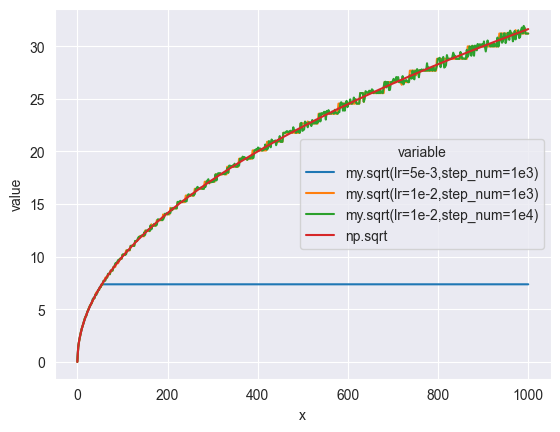

In [78]:
# 这个例子其实不太恰当，因为这里用的函数是不光滑的，函数值为0的位置前后的梯度有一个阶跃，但通过梯度下降法确实能求得结果
def sqrt(x, lr=1e-3, step_num=1000) -> float:
    """
    使用梯度法求平方根
    :param x: 入参
    :param lr: learn rate，学习率
    :param step_num: 步数
    :return:
    """
    # d的初始值不能设为0，因为函数在这里的梯度为0且前后对称，配合上中心差分，它就不动了
    # d也必须是可变的，不然gradient函数无法修改d了（因为下面的trick），这里的一维数组起着box的作用
    d = np.array([1], dtype=np.float64)
    # 该函数即为所需函数，在d=sqrt(x)的位置下它的值为0
    # 这里用了一个trick——函数通过闭包而非参数去引用d，函数的参数是无意义的，仅用于适配梯度函数中f的形式
    # 在使用该函数调用梯度时，即调用 gradient(h, np.array([d])) 时，梯度函数会尝试修改 d 再执行函数 h，其行为和改变函数参数是一致的
    # 这个trick特别适用于不知道函数的入参具体形式的情况下
    # 这里使用这个trick，因为后面求神经网络的损失函数的时候同样使用这种操作
    def h(_):
        return np.abs(x - d[0] * d[0])
    for _ in range(step_num):
        grad = gradient(h, d)
        d = d - grad * lr
    return d[0]

# 画点图验证一下，使用函数避免污染全局作用域
def drawSqrt():
    xs = np.linspace(0, 1000, 500)
    # 使用之前定义的sqrt的话性能会很差，因为它无法利用到numpy的并行计算功能，必须要使用for循环去调用
    # vectorize将函数从处理单元素的函数变为numpy数组的函数，但本质上仍旧是for循环，没有提高性能

    # 这在神经网络中无关紧要，因为计算损失函数的梯度时每趟训练只需要计算一次，不需要并发计算，但这里需要对多个位置同时计算它的梯度，这本该去并发计算
    # 这里实现一个更高性能的sqrt，不使用trick，使用适应一元函数的numerical_diff，
    # 它定义的形式因此能够适应numpy的并行计算，速度是上面的sqrt的百倍
    def sqrt(x,lr,step_num):
        def h(d):
            return np.abs(x - d * d)
        d = 1
        for _ in range(step_num):
            grad = numerical_diff(h, d)
            d = d - grad * lr
        return d
    # datas = pd.DataFrame({
    #     'x': xs,
    #     'my.sqrt(lr=1e-3,step_num=1e3)': np.vectorize(lambda x: sqrt(x, lr=1e-3,step_num=int(1e3)))(xs),
    #     'my.sqrt(lr=1e-2,step_num=1e3)': np.vectorize(lambda x: sqrt(x, lr=1e-2,step_num=int(1e3)))(xs),
    #     'np.sqrt': np.sqrt(xs)
    # })
    datas = pd.DataFrame({
        'x': xs,
        'my.sqrt(lr=5e-3,step_num=1e3)': sqrt(xs, lr=1e-3, step_num=int(1e3)),
        'my.sqrt(lr=1e-2,step_num=1e3)': sqrt(xs, lr=1e-2, step_num=int(1e3)),
        'my.sqrt(lr=1e-2,step_num=1e4)': sqrt(xs, lr=1e-2, step_num=int(1e4)),
        'np.sqrt': np.sqrt(xs)
    })
    sns.lineplot(data=datas.melt('x'), x='x', y='value', hue='variable')
drawSqrt()

梯度下降法有两个**超参数**（超参数即非神经网络通过训练得到，而是手动设定的参数）：学习率和步数，学习率表示每次要向梯度下降的方向移动多大距离，步数表示移动的次数，学习率需要被合适地设定，过大和过小都会导致无法得到正确结果，比如上面的例子。

# 反向传播/神经网络的学习

正向传播就是把输入喂给神经网络，得到输出的过程，**反向传播就是给定输入和期望的输出，根据期望的输出和实际的输出的关系去反向更新权重的过程**。神经网络中，可以使用梯度下降法进行反向传播。

首先需要定义我们需要应用梯度下降法的函数。**该函数的参数为权重矩阵，返回值代表期望输出和实际输出的“距离”**。该函数称为**损失函数**，我们可以通过梯度下降法逐渐逼近损失函数的最小值，**即让期望输出和实际输出最小的权重矩阵**，一趟训练的一般过程如下，和sqrt的形式基本一致：

```python
def train(W, x, t, lr, step_num):
    # W 是权重，x是输入，t是预测输出，lr是学习率，step_num是执行次数
    # 实际操作时，损失函数使用闭包去捕获权重矩阵
    def loss(W):
        return distance(precict(x, W), t)
    for _ in range(step_num):
        grad = gradient(loss, W)
        W = W - grad * lr
    return W
```

在实际操作中，我们不会对每一个训练数据都去进行梯度下降法，而是每次找到n个比如100个数据去做批处理，这既是去避免单个数据的特殊性，也能减少计算量。但同时也不会选择所有数据去进行学习，这又会增加计算量。**每次随机选择特定数量的数据去训练的方法称为mini-batch，训练过程中使用梯度下降法进行反向传播，这整个称为随机梯度下降法SGD**。

# 损失函数

损失函数需要求得期望输出和实际输出的“距离”，在处理多个输出时，损失函数需要求得每一个输出的“平均损失”，这个除以N就行。

常用的损失函数包括均方误差，交叉熵误差，它们的定义如下：

$$ mean_squared_error(y, t) = \frac{1}{2}\sum(y_k - t_k)^2 $$

$$ cross_entropy_error(y, t) = -\sum_{k}^{} t_{k}\log_{}{y_{k} } $$

In [79]:
# 注意这个定义只能处理单个数据
def mean_squared_error(y, t):
    """
    均方误差，为“距离”的平方的一半
    :param y: 实际输出
    :param t: 期望输出
    :return:
    """
    return np.sum((y - t) ** 2) / 2

# 交叉熵误差 ，修改了使之能处理一组数据的平均损失
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

# capstone 0: MNIST 识别手写数字

Hello, World! 这恐怕是最复杂的Hello World了。

MNIST数据集中的数据为28x28灰度像素表示的手写数字，其有60000条训练数据，10000条测试数据，每条数据包含该像素矩阵和对应数字值，下面拿它开刀，训练一个识别手写数字的神经网络。

数据文件从[这里](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)下载，读取数据的代码拷贝自[这里](https://www.kaggle.com/code/hojjatk/read-mnist-dataset?cellIds=1&kernelSessionId=9466282)。

首先设计神经网络的大小，这里设计一个两层神经网络（输入层，一个有权重的隐藏层，有权重的输出层），其中输入层的大小为28x28=784，即每个像素（这里丢掉长宽信息），第一个隐藏层为100个神经元，输出层为10个神经元，它们的输出分别表示数字为0-9的概率；隐藏层的激活函数使用sigmoid，输出层的激活函数使用softmax（这是个分类问题）。

在计算损失函数时，目标输出采用one-hot的形式，即只有一个元素为1的数组，如7会表示成`[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]`。

一般流程如下：

```
设置超参数（批大小，训练次数，训练集大小，学习率）
初始化神经网络

对每一次训练：
    随机抽取mini-batch

    计算这批数据的损失函数的梯度
    根据梯度和学习率更新参数 # 每一个mini-batch只移动一次梯度！

    记录当前的损失函数的返回值供统计
```

整个代码实现如下：

In [80]:
class TwoLayerNet:
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation_function: Callable = sigmoid,
                 loss_function: Callable = cross_entropy_error,
                 output_activation_function: Callable = softmax):
        self.loss_function = loss_function
        self.output_activation_function = output_activation_function
        self.activation_function = activation_function
        # 权重矩阵使用标准正态分布随机取值，偏置矩阵初始全为0
        self.w1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros(output_size)

    def predict(self, x):
        """
        正向传播
        :param x: 入参数组，需为二维，每一行为一个输入
        :return:
        """
        t1 = self.activation_function(x @ self.w1 + self.b1)
        return self.output_activation_function(t1 @ self.w2 + self.b2)

    def train(self, x, t, lr=0.1):
        """
        一次批训练，流程是根据输入，输出数据集去构造损失函数（它的参数是权重），然后求出此时的权重的梯度，将权重向梯度方向移动
        需注意的是，这里对每一个mini-batch，只移动一次！
        :param x: 输入数据集
        :param t: 期望输出数据集
        :param lr: 学习率
        :return: 当前的损失，以及梯度
        """
        def loss(_):
            """
            损失函数
            :param _: 权重，这里通过闭包引入，在predict中被使用
            :return: 当前权重下的损失
            """
            return self.loss_function(self.predict(x), t)

        w1 = gradient(loss, self.w1) # 该函数会尝试不断改变self.w1的值并调用loss函数，这里因为loss函数通过闭包引用了self.w1，即使参数没有改变/使用，输出值也会不同，因此能正常计算梯度
        b1 = gradient(loss, self.b1)
        w2 = gradient(loss, self.w2)
        b2 = gradient(loss, self.b2)
        self.w1 = self.w1 - w1 * lr
        self.b1 = self.b1 - b1 * lr
        self.w2 = self.w2 - w2 * lr
        self.b2 = self.b2 - b2 * lr

        return loss(0), (w1, b1, w2, b2)
    def accuracy(self, x, t):
        """
        根据测试数据计算准确率
        :param x: 测试数据输入
        :param t: 测试数据期望输出
        :return:
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1) # one hot转实际值
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

下面加载数据集，让银河燃烧吧。

In [81]:
# 需要将四个数据文件以及MnistDataloader.py都拷贝到 工作目录/mnist 才能执行这个cell
import pickle
import os
from mnist.MnistDataloader import MnistDataloader

# xx_images 为三维列表，第一维为每个图像，第二维为每个图像的每一行， 第三维为每一行的每一列
# xx_labels 为一维列表，其表示对应图像的取值
# 这里把图像全部展平，让每个图像成为长度为784的一维列表，把标签全部转换为one-hot形式
# 同时也缓存读取的数据，避免每次都读
def readMnist() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if os.path.exists('mnist/data.pickle'):
        with open('mnist/data.pickle', 'rb') as f:
            return pickle.load(f)
    (train_images, train_labels), (test_images, test_labels) = MnistDataloader(
        training_images_filepath = 'mnist/train-images.idx3-ubyte',
        training_labels_filepath = 'mnist/train-labels.idx1-ubyte',
        test_images_filepath     = 'mnist/t10k-images.idx3-ubyte',
        test_labels_filepath     = 'mnist/t10k-labels.idx1-ubyte').load_data()
    train_images = np.array(train_images).reshape(60000, 784)
    test_images = np.array(test_images).reshape(10000, 784)
    train_labels = np.eye(10)[train_labels] # np.eye(10) 生成10x10的对角数组，它的每一行正好是该行对应的one-hot表示
    test_labels = np.eye(10)[test_labels]
    res = (train_images, train_labels, test_images, test_labels)
    with open('mnist/data.pickle', 'xb') as f:
        pickle.dump(res, f)
    return res
train_images, train_labels, test_images, test_labels = readMnist()

先检查一下是否正确读取了，读取一下第一张图片看看效果：

5


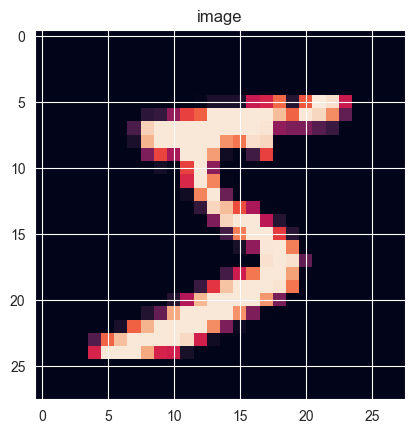

In [82]:
def img_show(img):
    from PIL import Image
    import matplotlib.pyplot as plt
    pil_img = Image.fromarray(np.uint8(img))
    plt.imshow(pil_img)
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image') # 图像题目
    plt.show()
print(np.argmax(train_labels[0])) # argmax 函数返回最大值的下标，使用其可以从one-hot还原到数字表示
img_show(train_images[0].reshape(28, 28))

开干！下面的代码同样做了缓存，保证每次测试都能用上上一次的结果。

在执行该代码时，会发现其执行速率是极为缓慢的，瓶颈可能在计算梯度时，计算梯度的时候会对每一个参数进行两次前向传播，在这里每一次计算梯度需要进行 `(w1.size + w2.size + b1.size + b2.size) * 2 = (784 * 100 + 100 * 10 + 100 + 10) * 2 = 159020`次前向传播……这效率是令人崩溃的。因此这里修改了隐藏层神经元的数量到10，把计算量基本降低了一个数量级，但好像仍然跑的通？？

In [83]:
# 诸超参数
train_size = train_images.shape[0] # 训练集大小
batch_size = 200 # mini-batch大小
iter_num = 500 # 迭代次数
learn_rate = 0.1 # 学习率

def doTraining():
    def createNet():
        if os.path.exists('mnist/net.pickle'):
            with open('mnist/net.pickle', 'rb') as f:
                return pickle.load(f)
        net = TwoLayerNet(784, 10, 10)
        return net

    net = createNet()

    train_loss_list = []

    for i in range(iter_num):
        # 每次从训练集中随意抽出batch_size个下标，获取对应图片和需求输出
        idxs = np.random.choice(train_size, batch_size)
        imgs = train_images[idxs]
        labels = train_labels[idxs]
        start = time.time()
        (loss, *_) = net.train(imgs, labels, learn_rate)
        end = time.time()
        print(f'{i + 1}/{iter_num}: {end - start:.2f}s, loss: {loss:.3f}, acc: {net.accuracy(test_images, test_labels):.4f}')

        with open('mnist/net.pickle', 'wb') as f:
                pickle.dump(net, f)
# doTraining()

这种全连接的，稀松平常的神经网络似乎称为MLP（多层感知机）。而这篇笔记或许就到这里了，因为下一章会对当前架构大改……看来这个是出不了成果了。但知识留着了。

最后的最后，必须得拿真实的数据去实践一下，无论效果如何，下面是一张28x112的png文件，内容是手写的2026，看看我们的人工智障会输出什么东西。

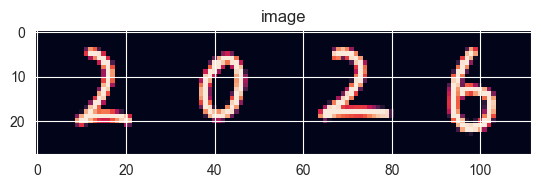

[2 7 2 5]


/var/folders/_q/85kvfkw971n8q6bnnh48hpph0000gn/T/ipykernel_8502/1032220136.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [84]:
# 实现来自chatGPT
def split_image(image_path):
    from PIL import Image
    img = Image.open(image_path)
    width, height = img.size
    result = []
    for i in range(0, height, 28):
        for j in range(0, width, 28):
            box = (j, i, j+28, i+28)
            gray_pixels = []
            for pixel in img.crop(box).getdata():
                gray = round(0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2])
                gray_pixels.append(gray)
            result.append(255 - np.array(gray_pixels))
    return np.array(result)

images = split_image('mnist/2026.png')
img_show(np.concatenate(images.reshape(4, 28, 28), axis=1))
with open('mnist/net.pickle', 'rb') as f:
    net = pickle.load(f)
print(np.argmax(net.predict(images), axis=1))